In [289]:
from SimDataDB import *
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]
# Macro for making consistent color+markers throughout
from itertools import cycle
from collections import defaultdict
colors = cycle("rgbycmk")
markers = cycle("+x*d")
colorkey = defaultdict(lambda :colors.next())
markerkey = defaultdict(lambda :markers.next())
mykwargs = lambda s:{'color':colorkey[s],'marker':markerkey[s],'label':s}
sdb = SimDataDB('PeriFlakes/results_ficticious.db')
def mysavefig(fname,fig=None):
    #return
    plt.savefig("/Users/afq/Documents/Dropbox/LBL/Presentations/peridynamics/assets/plots/"+fname)

In [290]:
H = 2.0 ; T = 1.0 ; E = 1.0 ; nu = 0.25;

solutions = \
    {'uniaxial': lambda x : ((x[:,1]+H/2.0)*
                 np.array([[ 0,
                  T*(2.0*nu**2+nu-1.0)/(E*(nu-1)) ]]).T).T,
     'isotropic':lambda x :  ((x[:,1]+H/2.0)*
         np.array([[
             T*(1.0-nu-2.0*nu**2)/E,
             T*(1.0-nu-2.0*nu**2)/E ]]).T).T,
      'shear':   lambda x:  ((x[:,1]+H/2.0)*np.array([[
          2.0*T*(1.0+nu)/E,
          0]]).T).T
    }

In [291]:
def fetch(table,surf,method,N,weight='cubic',RF=1.5):
    return sdb.Query("""
            SELECT N,x,u FROM {table} WHERE 
            surface='{surface}' and method='{method}' 
            and weight='{weight}' and N={N} and RF={RF}""".format(
            table=table,surface=surf,method=method,weight=weight,N=N,RF=RF))

none


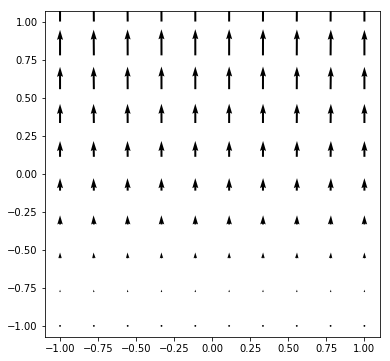

trivial


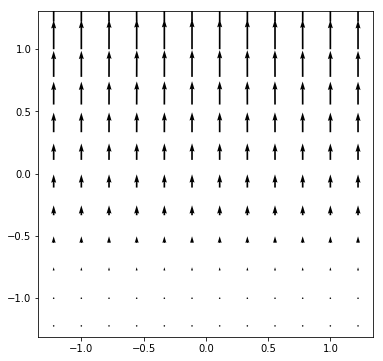

bobaru


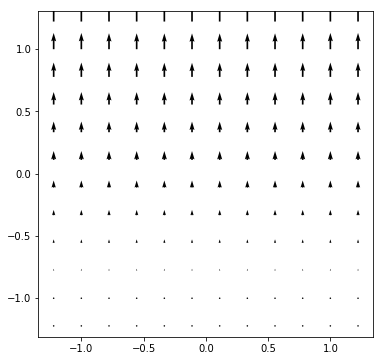

In [292]:
for surf in ['none','trivial','bobaru']:
    N,x,u = fetch('uniaxial',surf,'Silling',10,weight='const')[0]
    print surf
    N = int((u.shape[0]/2)**0.5)

    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    #ua = 
    ax = plt.gca()
    ax.quiver(x[:,:,0],x[:,:,1],u[:,:,0],u[:,:,1],angles='uv',scale_units='xy',scale=10)
    ax.set_aspect('equal', 'datalim')
    plt.show()

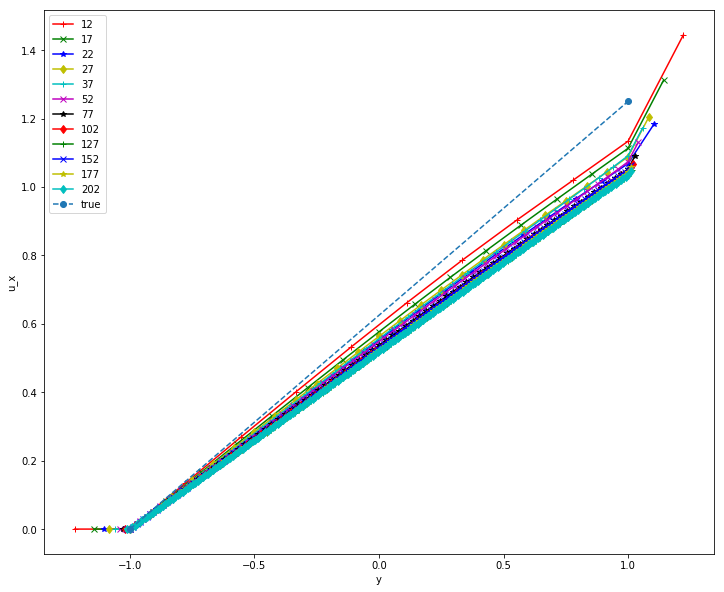

In [334]:
#Ns = [_[0] for _ in sdb.Query("SELECT DISTINCT method FROM uniaxial")]
plt.rcParams['figure.figsize'] = [12, 10]
res = sdb.Query("""SELECT N,x,u FROM {table} WHERE 
            surface='{surface}' and method='{method}' 
            and weight='{weight}' and RF={RF}""".format(
            table='isotropic',surface='bobaru',method='Silling',weight='const',RF=1.5))
for N,x,u in res:
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    plt.plot(x[:,N/2,1],u[:,N/2,1],**mykwargs(N))
plt.plot([-1,1],[0,solutions['isotropic'](np.array([[0,1]]))[0,1]],'o--',label="true")
plt.xlabel('y'); plt.ylabel('u_x');
plt.legend(loc=2)

Silling
Fbased
Fstab_Silling
Oterkus2


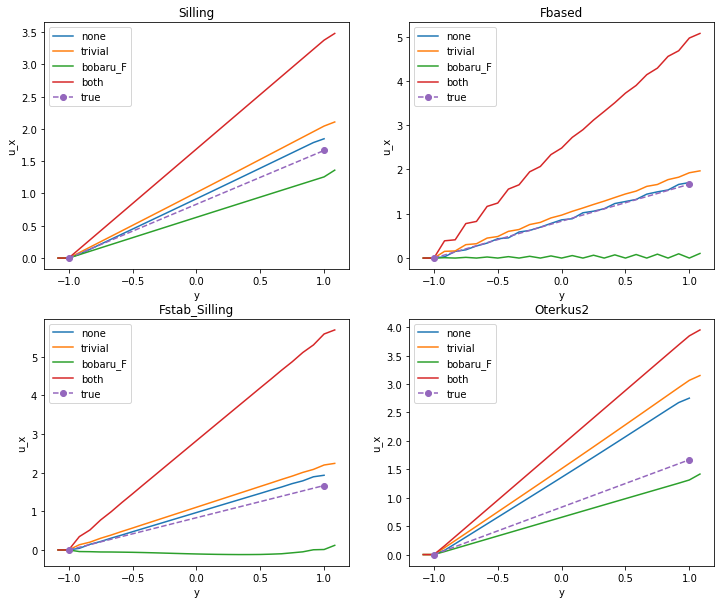

In [336]:
plt.rcParams['figure.figsize'] = [12, 10]
for i,m in enumerate(['Silling','Fbased','Fstab_Silling','Oterkus2']):
    print m
    plt.subplot(2,2,i+1)
    plt.title(m)
    for surf in ['none','trivial','bobaru_F','both']:
        Ns = [_[0] for _ in sdb.Query("SELECT DISTINCT method FROM uniaxial")]
        N,x,u = fetch('uniaxial',surf,m,25,weight='cubic')[0]
        N = int((u.shape[0]/2)**0.5)
        u = u.reshape(N,N,2)
        x = x.reshape(N,N,2)
        plt.plot(x[:,N/2,1],u[:,N/2,1],label=surf)
    plt.plot([-1,1],[0,solutions['uniaxial'](np.array([[0,1]]))[0,1]],'o--',label="true")
    plt.xlabel('y'); plt.ylabel('u_x');
    plt.legend(loc=2)
mysavefig('bc_solutions_uniaxial.png')
plt.show()

In [315]:
def e(tab,met,surf):
    res = sdb.Query("SELECT N,x,u FROM {0} WHERE surface='{1}' and method='{2}' and weight='cubic' and RF=1.5".format(tab,surf,met))
    errors = []
    hs = []
    for N,x,u in res:
        n2 = int((u.shape[0]/2)**0.5)
        u = u.reshape(n2,n2,2)
        x = x.reshape(n2,n2,2)
        nslc = slice(n2/2-3,n2/2+4)
        xc = x[nslc,nslc,:].reshape(-1,2)
        uc = u[nslc,nslc,:].reshape(-1,2)
        diff = np.linalg.norm((uc - solutions[tab](xc)))
        errors.append(np.abs(diff/np.linalg.norm(solutions[tab](xc))))
        hs.append(2.0/float(N))
    return (hs,errors)

Silling


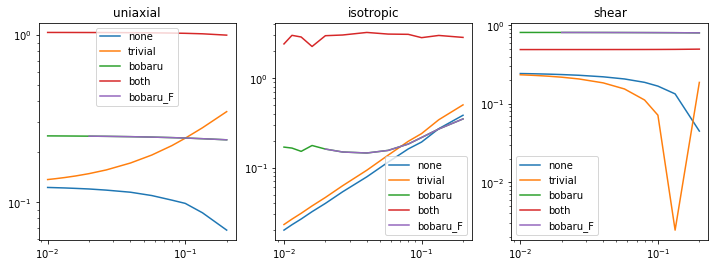

Fbased


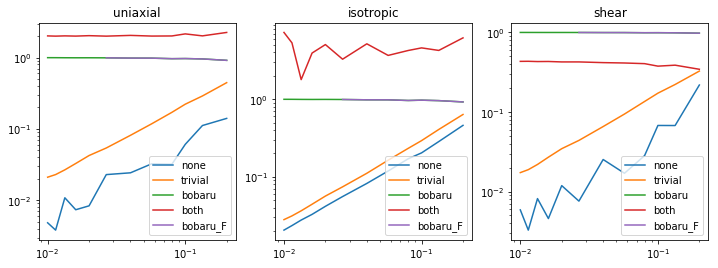

Fstab_Silling


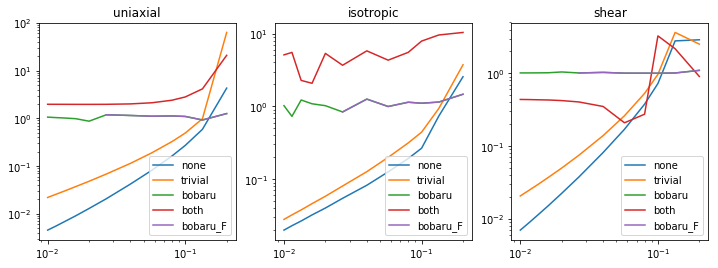

Oterkus2


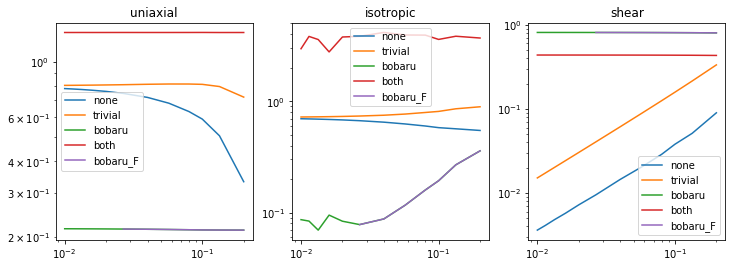

In [337]:
plt.rcParams['figure.figsize'] = [12, 4]
for m in ['Silling','Fbased','Fstab_Silling','Oterkus2']:
    print m
    plt.subplot(311)
    for i,p in enumerate(['uniaxial','isotropic','shear']):
        plt.subplot(1,3,i+1)
        plt.title (p)
        for s in ['none','trivial','bobaru','both','bobaru_F']:
            plt.loglog(*e(p,m,s),label=s)
        plt.legend()
    mysavefig('bcs_'+m+'.png')
    plt.show()

## A Deeper Look

Why aren't these methods converging? Let's go back to the other database

In [338]:
sdbr = SimDataDB('PeriFlakes/results.db')

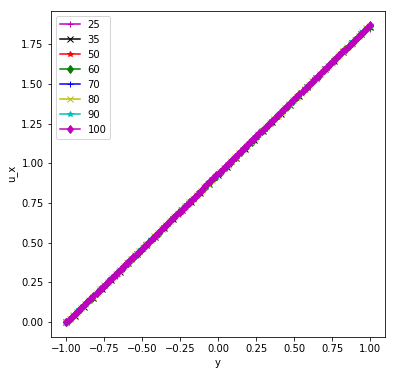

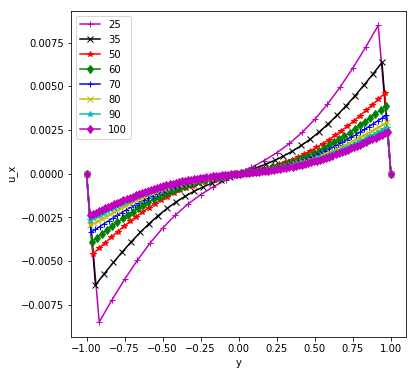

In [385]:
plt.rcParams['figure.figsize'] = [6, 6]
res = sdbr.Query("""SELECT N,u FROM {table} WHERE 
            method='{method}' 
            and weight='{weight}' and RF={RF}""".format(
            table='uniaxial',method='Silling',weight='cubic',RF=1.5))
for N,u in res:
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    xx,yy = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
    plt.plot(yy[:,N/2],u[:,N/2,1],**mykwargs(N))
plt.xlabel('y'); plt.ylabel('u_x');
plt.legend(loc=2)
plt.show()
for N,u in res:
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    xx,yy = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
    plt.plot(xx[N/2,:],u[N/2,:,0],**mykwargs(N))
# plt.plot([-1,1],[0,solutions['uniax'](np.array([[0,1]]))[0,1]],'o--',label="true")
plt.xlabel('y'); plt.ylabel('u_x');
plt.legend(loc=2)
plt.show()

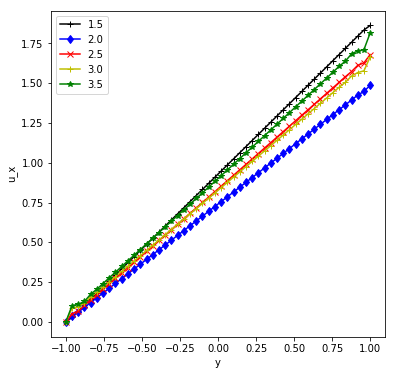

1.5
2.0
2.5
3.0
3.5


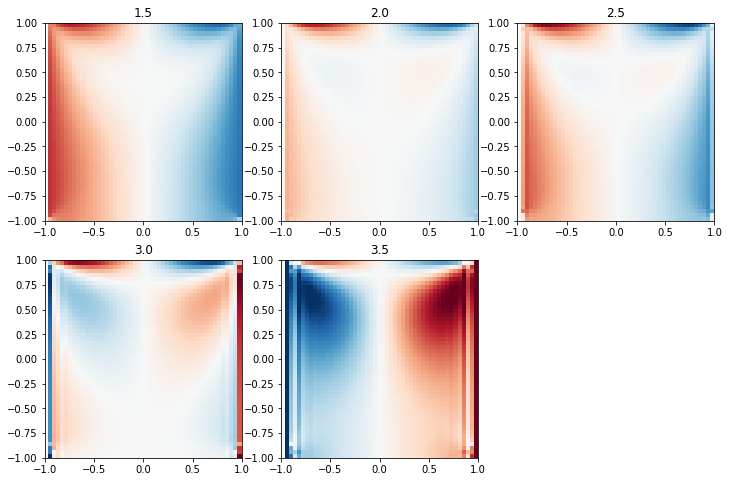

1.5 none
2.0 none
2.5 none
3.0 none
3.5 none


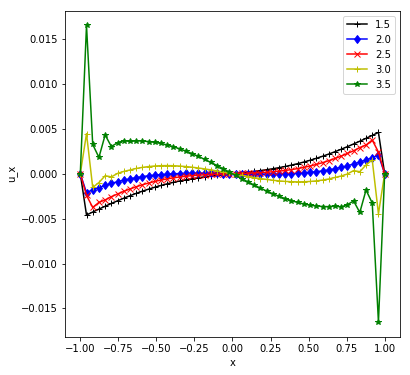

In [438]:
plt.rcParams['figure.figsize'] = [6, 6]
res = sdb.Query("""SELECT RF,surface,x,u FROM {table} WHERE 
            method='{method}' 
            and weight='{weight}' and N=50 and surface='none'""".format(
            table='uniaxial',method='Silling',weight='cubic'))
for RF,surf,x,u in res:
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    xx,yy = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))
    plt.plot(yy[:,N/2],u[:,N/2,1],**mykwargs(RF))
plt.xlabel('y'); plt.ylabel('u_x');
plt.legend(loc=2)
plt.show()
plt.rcParams['figure.figsize'] = [12, 8]
for i,(RF,surf,x,u) in enumerate(res):
    print RF
    plt.subplot(2,3,i+1)
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    if i==0:
        zrng = max(abs(u[:,:,0].min()), u[:,:,0].max())
    plt.pcolormesh(x[:,:,0],x[:,:,1],u[:,:,0],cmap='RdBu',vmin=-zrng,vmax=zrng)
    plt.title(RF)
    #plt.show()
# plt.colorbar()
mysavefig('ux_Silling_color.png')
plt.show()

plt.rcParams['figure.figsize'] = [6, 6]
for RF,surf,x,u in res:
    print RF, surf
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    plt.plot(xx[N/2,:],u[N/2,:,0],**mykwargs(RF))
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');
mysavefig('ux_Silling.png')
plt.show()
# plt.plot([-1,1],[0,solutions['uniax'](np.array([[0,1]]))[0,1]],'o--',label="true")


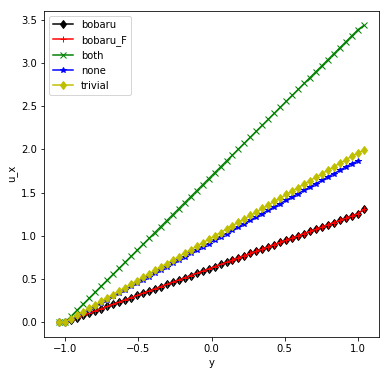

1.5 bobaru
1.5 bobaru_F
1.5 both
1.5 none
1.5 trivial


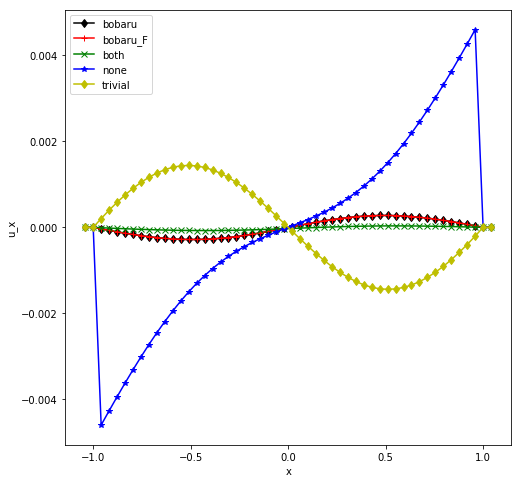

3.5 none
3.5 trivial


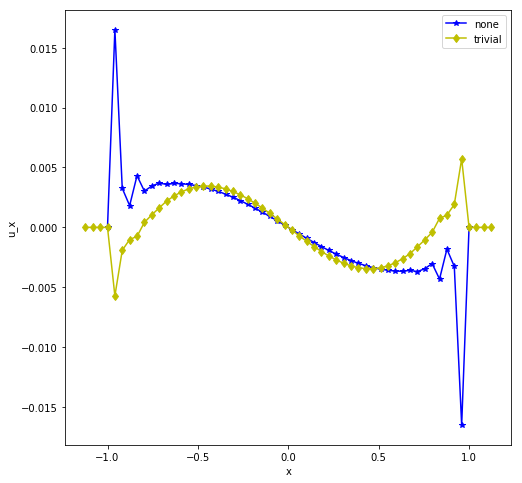

In [441]:
plt.rcParams['figure.figsize'] = [6, 6]
res = sdb.Query("""SELECT RF,surface,x,u FROM {table} WHERE 
            method='{method}' 
            and weight='{weight}' and N=50 and RF=1.5""".format(
            table='uniaxial',method='Silling',weight='cubic'))
for RF,surf,x,u in res:
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    plt.plot(x[:,N/2,1],u[:,N/2,1],**mykwargs(surf))
plt.xlabel('y'); plt.ylabel('u_x');
plt.legend(loc=2)
plt.show()

plt.rcParams['figure.figsize'] = [8, 8]
for RF,surf,x,u in res:
    print RF, surf
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    plt.plot(x[N/2,:,0],u[N/2,:,0],**mykwargs(surf))
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');
mysavefig('ux_Silling_surface_1.5.png')
plt.show()

plt.rcParams['figure.figsize'] = [8, 8]
res = sdb.Query("""SELECT RF,surface,x,u FROM {table} WHERE 
            method='{method}' 
            and weight='{weight}' and N=50 and RF=3.5 and (surface='none' or surface='trivial')""".format(
            table='uniaxial',method='Silling',weight='cubic'))
for RF,surf,x,u in res:
    print RF, surf
    N = int((u.shape[0]/2)**0.5)
    u = u.reshape(N,N,2)
    x = x.reshape(N,N,2)
    plt.plot(x[N/2,:,0],u[N/2,:,0],**mykwargs(surf))
plt.legend()
plt.xlabel('x'); plt.ylabel('u_x');
mysavefig('ux_Silling_surface_3.5.png')
plt.show()
# plt.plot([-1,1],[0,solutions['uniax'](np.array([[0,1]]))[0,1]],'o--',label="true")